In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
app_train = pd.read_csv("/content/application_train.csv")
app_test = pd.read_csv("/content/application_train.csv")
credit_card_balance = pd.read_csv("/content/credit_card_balance.csv")

In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 5.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Function to reduce memory usage
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:  # Exclude string columns
            if pd.api.types.is_integer_dtype(col_type):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif pd.api.types.is_float_dtype(col_type):
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Assuming your CSV files are already loaded as app_train, app_test, credit_card_balance, etc.

# Step 1: Reduce memory usage for large DataFrames
app_train = reduce_memory_usage(app_train)
app_test = reduce_memory_usage(app_test)
credit_card_balance = reduce_memory_usage(credit_card_balance)

# Select specific columns from credit_card_balance for merging
columns_to_merge = ['SK_ID_CURR', 'AMT_BALANCE', 'SK_DPD']
credit_card_balance_selected = credit_card_balance[columns_to_merge]

# Step 2: Use Dask for large dataset handling
app_train_dd = dd.from_pandas(app_train, npartitions=10)
credit_card_balance_dd = dd.from_pandas(credit_card_balance_selected, npartitions=10)

# Step 3: Rename columns in app_test to avoid duplicates during the merge
app_test_renamed = app_test[['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].copy()
app_test_renamed.columns = ['SK_ID_CURR', 'TEST_EXT_SOURCE_1', 'TEST_EXT_SOURCE_2', 'TEST_EXT_SOURCE_3']

# Step 4: Merge DataFrames on SK_ID_CURR using Dask
merged_data_dd = dd.merge(app_train_dd, credit_card_balance_dd, on='SK_ID_CURR', how='left')
merged_data_dd = dd.merge(merged_data_dd, app_test_renamed, on='SK_ID_CURR', how='left')

# Step 5: Compute the final merged DataFrame
merged_data = merged_data_dd.compute()

# Step 6: Handle missing values for EXT_SOURCE columns
ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
existing_ext_source_cols = [col for col in ext_source_cols if col in merged_data.columns]

imputer = SimpleImputer(strategy='mean')  # Define imputer for EXT_SOURCE

for col in existing_ext_source_cols:
    if merged_data[col].isna().all():
        print(f"{col} is completely NaN and will be dropped.")
        merged_data.drop(col, axis=1, inplace=True)
    else:
        merged_data[col] = imputer.fit_transform(merged_data[[col]])

# Step 7: Handle missing values for 'AMT_BALANCE' if it exists
if 'AMT_BALANCE' in merged_data.columns:
    if merged_data['AMT_BALANCE'].isna().all():
        print("AMT_BALANCE is completely NaN and will be dropped.")
        merged_data.drop('AMT_BALANCE', axis=1, inplace=True)
    else:
        merged_data['AMT_BALANCE'] = imputer.fit_transform(merged_data[['AMT_BALANCE']])

# Step 8: Handle missing values in SK_DPD (categorical -> numerical conversion)
if 'SK_DPD' in merged_data.columns:
    sk_dpd_imputer = SimpleImputer(strategy='median')
    merged_data['SK_DPD'] = sk_dpd_imputer.fit_transform(merged_data[['SK_DPD']])

# Convert the 'Y'/'N' values in 'FLAG_OWN_CAR' to 1/0
merged_data['FLAG_OWN_CAR'] = merged_data['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})

# Correct: Perform one-hot encoding on 'CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE'
categorical_columns = ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE']
merged_data = pd.get_dummies(merged_data, columns=categorical_columns, drop_first=True)

# Convert boolean columns to integers (0/1)
boolean_columns = merged_data.select_dtypes(include='bool').columns
merged_data[boolean_columns] = merged_data[boolean_columns].astype(int)

# Step 9: Scaling numerical features
numerical_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'SK_DPD', 'AMT_BALANCE']
numerical_columns += [col for col in existing_ext_source_cols if col in merged_data.columns]

# Step 9: Scaling numerical features using MinMaxScaler instead of StandardScaler
scaler = MinMaxScaler()
merged_data[numerical_columns] = scaler.fit_transform(merged_data[numerical_columns])

# Step 10: Select input parameters for the model
input_parameters = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_BALANCE', 'AMT_ANNUITY', 'SK_DPD', 'CNT_CHILDREN', 'FLAG_OWN_CAR']

# Add EXT_SOURCE columns if they exist
input_parameters += [col for col in existing_ext_source_cols if col in merged_data.columns]

# Add one-hot encoded columns for 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE'
input_parameters += [col for col in merged_data.columns if 'NAME_CONTRACT_TYPE' in col]
input_parameters += [col for col in merged_data.columns if 'CODE_GENDER' in col]
input_parameters += [col for col in merged_data.columns if 'NAME_FAMILY_STATUS' in col]
input_parameters += [col for col in merged_data.columns if 'NAME_INCOME_TYPE' in col]
input_parameters += [col for col in merged_data.columns if 'NAME_HOUSING_TYPE' in col]

# Step 11: Filter merged data for input parameters and target
training_data = merged_data[input_parameters + ['TARGET']]
print(training_data.head(10))
# Split the data into features and target
X = training_data[input_parameters]
y = training_data['TARGET']

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_BALANCE  AMT_ANNUITY  SK_DPD  \
0          0.104407    0.365513     0.076606     0.247072     0.0   
1          0.127975    0.148875     0.054557     0.364146     0.0   
2          0.045487    0.062500     0.076606     0.064898     0.0   
3          0.087909    0.296875     0.076606     0.203604     0.0   
4          0.057271    0.083125     0.076606     0.100604     0.0   
5          0.127975    0.281250     0.076606     0.301137     0.0   
6          0.033703    0.070234     0.076606     0.129189     0.0   
7          0.085553    0.142187     0.076606     0.305120     0.0   
8          0.045487    0.044477     0.076606     0.092538     0.0   
9          0.057271    0.140625     0.076606     0.143870     0.0   

   CNT_CHILDREN  FLAG_OWN_CAR  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  ...  \
0             0             1      0.669218      0.559481      0.703738  ...   
1             0             1      0.532414      0.934734      0.735931  ...   


In [4]:
pip install pandas scikit-learn xgboost catboost lightgbm matplotlib seaborn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [5]:
# Import necessary libraries for models and preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Create a function to build a DNN model for binary classification
def create_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a list to hold models with preprocessing steps (imputation + scaling)
models = {
    'Neural Network': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(max_iter=500))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', RandomForestClassifier())
    ]),
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=500))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]),
    'CatBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', CatBoostClassifier(silent=True))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LGBMClassifier())
    ]),
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),  # SVM performs better with scaled data
        ('classifier', SVC(probability=True))  # Enable probability estimates for AUC-ROC
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),  # KNN benefits from scaling
        ('classifier', KNeighborsClassifier())
    ]),
    'Naive Bayes': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', GaussianNB())  # Naive Bayes does not need scaling
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', AdaBoostClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', DecisionTreeClassifier())
    ]),
    'DNN': create_dnn_model(input_dim=X_train.shape[1])  # Assuming your features are preprocessed
}

# Step 6: Model Building and Training
results = {}

for model_name, model in models.items():
    if model_name == 'DNN':
        # Special handling for DNN model (sequential model instead of sklearn pipeline)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
        y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)
    else:
        model.fit(X_train, y_train)  # Train the model
        y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # AUC-ROC Curve
    if model_name == 'DNN':  # Special handling for DNN predict_proba
        y_pred_proba = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    elif hasattr(model.named_steps['classifier'], 'predict_proba'):  # Ensure model supports predict_proba
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc, fpr, tpr = None, None, None

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

    # Print results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: Neural Network
Accuracy: 0.9036
F1 Score: 0.1156
Confusion Matrix:
[[1424   47]
 [ 106   10]]

Model: Random Forest
Accuracy: 0.9269
F1 Score: 0.0333
Confusion Matrix:
[[1469    2]
 [ 114    2]]

Model: Logistic Regression
Accuracy: 0.9263
F1 Score: 0.0168
Confusion Matrix:
[[1469    2]
 [ 115    1]]



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:17:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Accuracy: 0.9231
F1 Score: 0.0896
Confusion Matrix:
[[1459   12]
 [ 110    6]]

Model: CatBoost
Accuracy: 0.9275
F1 Score: 0.0496
Confusion Matrix:
[[1469    2]
 [ 113    3]]

[LightGBM] [Info] Number of positive: 492, number of negative: 5853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 6345, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077541 -> initscore=-2.476231
[LightGBM] [Info] Start training from score -2.476231
Model: LightGBM
Accuracy: 0.9275
F1 Score: 0.1085
Confusion Matrix:
[[1465    6]
 [ 109    7]]

Model: SVM
Accuracy: 0.9269
F1 Score: 0.0000
Confusion Matrix:
[[1471    0]
 [ 116    0]]

Model: K-Nearest Neighbors
Accuracy: 0.9200
F1 Score: 0.0451
Confusi

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoost
Accuracy: 0.9238
F1 Score: 0.1037
Confusion Matrix:
[[1459   12]
 [ 109    7]]

Model: Decision Tree
Accuracy: 0.8715
F1 Score: 0.1707
Confusion Matrix:
[[1362  109]
 [  95   21]]

Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8856 - loss: 0.3689
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9285 - loss: 0.2432
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9239 - loss: 0.2425
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9198 - loss: 0.2503
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9187 - loss: 0.2482
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9229 - loss: 0.2393
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9279 - loss: 0.2283
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9167 - loss: 0.2544
Epoch 9/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9221 - loss: 0.2418
Epoch 10/10
199/199 ━━━━━━━━━

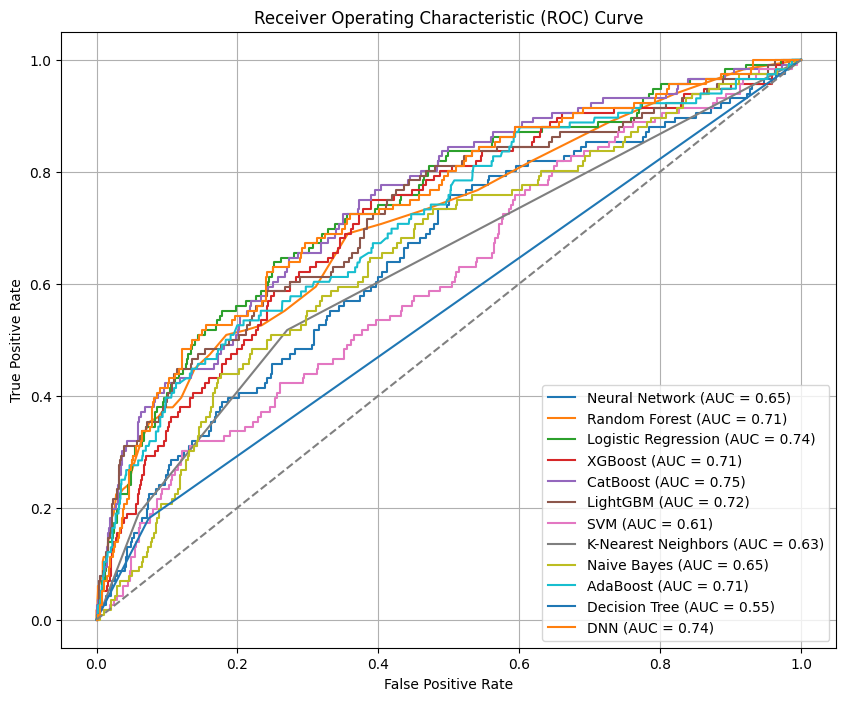

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 7: Plotting AUC-ROC Curves
plt.figure(figsize=(10, 8))

for model_name, metrics in results.items():
    plt.plot(metrics['fpr'], metrics['tpr'], label=f'{model_name} (AUC = {metrics["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()